包导入

In [1]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel


总共有2种f(x)：
1. f(0)=0,f(1)=0
2. f(0)=0,f(1)=1
3. f(0)=1,f(1)=0
4. f(0)=1,f(1)=1

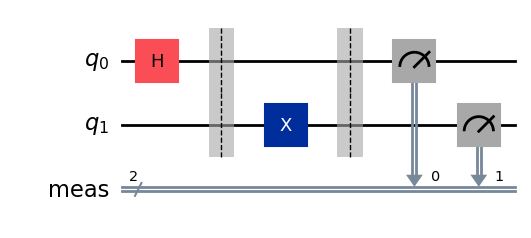

In [18]:
# 创建一个量子并行性电路
# Step 1: Map
 
from qiskit import QuantumCircuit
 
qc = QuantumCircuit(2)
 
 
def twobit_function(case: int):
    """
    Generate a valid two-bit function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")
# q2 = f(x)
# 传入1，那么什么也不做，则f(x)输出始终是0，即q2始终是0
# 传入2，相当于第二种情况
# 传入3，相对于2多了一个x门，属于第三种情况
# 传入4，q2输出始终是1
    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f 
 
qc.h(0)
qc.barrier()
qc.compose(twobit_function(4), inplace=True)
qc.measure_all()

 
qc.draw("mpl")

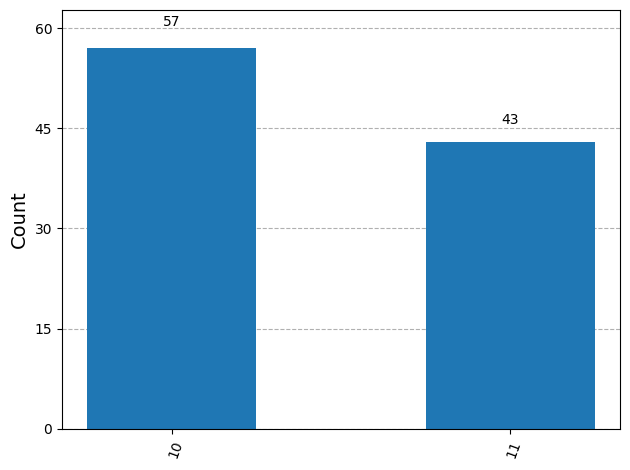

In [19]:
sampler = Sampler()
job = sampler.run([qc],shots=100)
job_res = job.result()
counts = job_res[0].data.meas.get_counts()

# Step 4: Visualize and analyze results
 
## Analysis
from qiskit.visualization import plot_histogram
 
plot_histogram(counts)


## Deutsch-Jozsa Algorithm
确定函数是平衡函数还是常数函数。也就是说，如果函数是平衡函数，则函数的输出一半时间为 0，另一半时间为 1。如果函数是常数函数，则函数的输出要么始终为 0，要么始终为 1

虽然上述电路实现了四种f(x)，且在未测量之前实现了并行计算，但是要测量时还是只能得到一个结果
1. Deutsch对上面的“量子并行”电路做了一点调整，在所有量子比特上都准备了一个叠加态，并且使用了一个辅助量子比特
2. 此时的f(x)接受一个{0,1}n的比特串，返回{0,1}
3. 辅助量子比特是y，而输入是x
4. 通过辅助量子比特，将其系数提到输入量子比特上，对输出进行了相位反冲，也就是本来输出就是输入的X态，现在加了一个相位系数(-1)的f(x)次
5. 最后在用H门
6. 如果函数是常数函数，该算法将返回一个全0的位串；如果函数是平衡函数，则返回一个至少包含一个1的位串。
7. 最终的结果说明：在量子比特共舞中，当最终的输出态为全0串时，此时输出全0串的概率等于100，因为若不是全0串，其状态的系数等于0，概率为0，所以必然100%是全0串

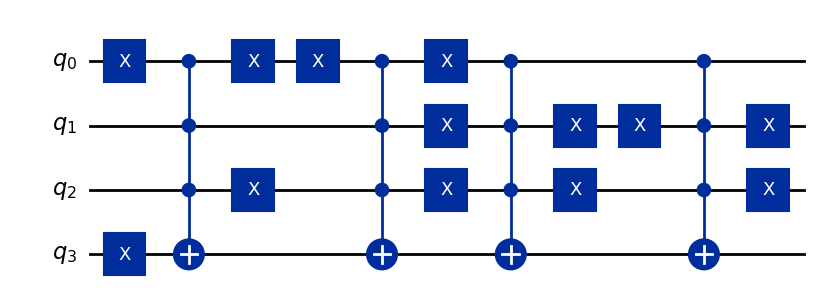

In [20]:

# 定义一个f(x)黑箱：这个函数要么是常数函数（对所有输入，输出相同），要么是平衡函数（对一半输入输出0，另一半输出1）
from qiskit import QuantumCircuit
import numpy as np
 
 
def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """
 
    qc_dj = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubits with 50% chance
        qc_dj.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance.
        return qc_dj
 
    # If the "if" statement above was "TRUE" then we've returned the constant
    # function and the function is complete. If not, we proceed in creating our
    # balanced function. Everything below is to produce the balanced function:
 
    # select half of all possible states at random:
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
 
    def add_cx(qc_dj, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc_dj.x(qubit)
        return qc_dj
 
    for state in on_states:
        # qc_dj.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc_dj = add_cx(qc_dj, f"{state:0b}")
        qc_dj.mcx(list(range(num_qubits)), num_qubits)
        qc_dj = add_cx(qc_dj, f"{state:0b}")
 
    # qc_dj.barrier()
 
    return qc_dj
 
 
n = 3  # number of input qubits
 
oracle = dj_function(n)
 
display(oracle.draw("mpl"))

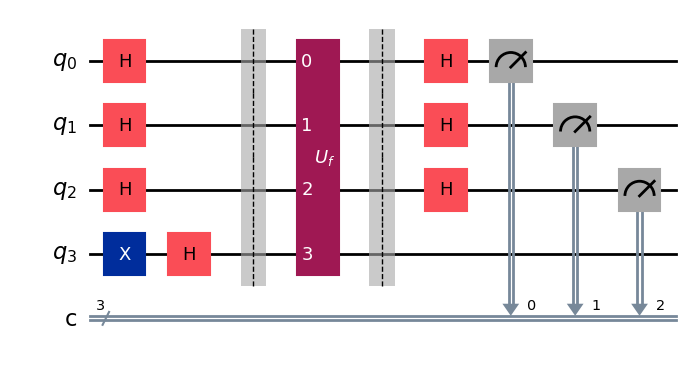

In [22]:
# 将f(x)作为一个黑箱(门)加入电路，方便绘制
blackbox = oracle.to_gate()
blackbox.label = "$U_f$"
 
qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)  # 辅助量子比特
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(blackbox, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))
 
qc_dj.decompose()
qc_dj.draw("mpl")

In [43]:
from qiskit.primitives import DataBin
sampler2 = Sampler()
job = sampler2.run([qc_dj],shots=200).result()
counts = job[0].data.c.get_counts()
# Step 4: Visualize and analyze results
print(isinstance(job[0].data, DataBin))
## Analysis，这里仅仅运行一次，可以看出，输出结果
print(counts)
 
if (
    "0" * n in counts
):  # The D-J algorithm returns all zeroes if the function was constant，因为是100%的概率
    print("constant")
else:
    print("balanced")  # anything other than all zeroes means the function is balanced.

True
{'011': 200}
balanced
